# Preliminary Steps

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
# import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('punkt_tab')
import string
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wdemelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/wdemelo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
df = pd.read_csv('fake_job_postings.csv')
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [30]:
df['text'] = df['title'] + df['description'] + df['company_profile'] + df['requirements'] + df['benefits']
dfs = df.loc[df['fraudulent'] == 0, 'text']
dfs.to_csv('data2.txt', sep='\t', index=False)

# Data Cleaning

In [3]:
def preprocessor(sentences):

    # Necessary steps - calls specific items used for preprocessing functions
    processed_sentences = []
    translator = str.maketrans('', '', string.punctuation)
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    # Preprocessing steps (non-essential steps can be removed)
    for sentence in sentences:

        # Turns all words lowercase
        sentence = sentence.lower()

        # Removes punctuation
        pl_sentence = sentence.translate(translator)

        # Tokenizes sentence
        tokens = word_tokenize(pl_sentence)

        # Removes stopwords
        sw_tokens = [token for token in tokens if token not in stop_words]

        # # Stems words
        # st_tokens = [stemmer.stem(token) for token in sw_tokens]

        # # Removes uncommon words
        # freq_dist = FreqDist(tokens)
        # threshold = 1
        # fq_tokens = [token for token in tokens if freq_dist[token] > threshold]

        processed_sentences.append(" ".join(sw_tokens))
    return processed_sentences

In [4]:
# Remove duplicates
df = df.drop_duplicates()

# # Get salary data: range (distance between proposed salaries) and average (mean of proposed salaries)
# salary = []
# for item in df['salary_range']:
#     try:
#         x = item.split("-")
#         x[0] = int(x[0])
#         x[1] = int(x[1])
#         salary.append(x)
#     except:
#         salary.append([np.nan, np.nan])
# # Range variable
# salary_rng = []
# # Average variable
# salary_avg = []
# for item in salary:
#     try:
#         salary_rng.append(abs(item[0]-item[1]))
#         salary_avg.append((item[0]+item[1])/2)
#     except:
#         salary_rng.append(np.nan)
#         salary_avg.append(np.nan)
# df['salary_rng'] = salary_rng
# df['salary_avg'] = salary_avg

# Get country variable: country denoted in job posting:
countries = []
for item in df['location']:
    try:
        countries.append(item.split(",")[0])
    except:
        countries.append(np.nan)
df['country'] = countries

# Clean text data
text_features = ['title', 'description', 'company_profile', 'requirements', 'benefits']
for item in text_features:
    df[item] = df[item].fillna('')
    df[item] = preprocessor(df[item])

# Clean categorical data
categorical_features = ['country', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for item in categorical_features:
    df[item] = df[item].fillna('Unknown')
    df[item] = [entry.lower() for entry in df[item]]

In [5]:
# Drop unnecessary columns
drop_columns = ['job_id', 'salary_range', 'location', 'department']
df_sep = df.drop(columns=drop_columns)

print(df_sep.shape)
df_sep.head()


(17880, 15)


,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country
0,marketing intern,food52 weve created groundbreaking awardwinnin...,food52 fastgrowing james beard awardwinning on...,experience content management systems major pl...,,0,1,0,other,internship,unknown,unknown,marketing,0,us
1,customer service cloud video production,90 seconds worlds cloud video production servi...,organised focused vibrant awesomedo passion cu...,expect youyour key responsibility communicate ...,get usthrough part 90 seconds team gainexperie...,0,1,0,full-time,not applicable,unknown,marketing and advertising,customer service,0,nz
2,commissioning machinery assistant cma,valor services provides workforce solutions me...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,,0,1,0,unknown,unknown,unknown,unknown,unknown,0,us
3,account executive washington dc,passion improving quality life geography heart...,company esri – environmental systems research ...,education bachelor ’ master ’ gis business adm...,culture anything corporate—we collaborative cr...,0,1,0,full-time,mid-senior level,bachelor's degree,computer software,sales,0,us
4,bill review manager,spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualificationsrn license state texasdiploma ba...,full benefits offered,0,1,1,full-time,mid-senior level,bachelor's degree,hospital & health care,health care provider,0,us


In [6]:
df['text_features'] = df['title'] + df['company_profile'] + df['description'] + df['requirements'] + df['benefits']

drop_columns = ['job_id', 'salary_range', 'location', 'department', 'title', 'company_profile', 'description', 'requirements', 'benefits']
df_concat = df.drop(columns=drop_columns)

categorical_features = ['country', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

print(df_concat.shape)
df_concat.head()

(17880, 11)


,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,text_features
0,0,1,0,other,internship,unknown,unknown,marketing,0,us,marketing internfood52 weve created groundbrea...
1,0,1,0,full-time,not applicable,unknown,marketing and advertising,customer service,0,nz,customer service cloud video production90 seco...
2,0,1,0,unknown,unknown,unknown,unknown,unknown,0,us,commissioning machinery assistant cmavalor ser...
3,0,1,0,full-time,mid-senior level,bachelor's degree,computer software,sales,0,us,account executive washington dcpassion improvi...
4,0,1,1,full-time,mid-senior level,bachelor's degree,hospital & health care,health care provider,0,us,bill review managerspotsource solutions llc gl...


# Training (Separate Approach)

In [7]:
# Features and target
X = df_sep.drop('fraudulent', axis=1)
y = df_sep['fraudulent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (14304, 14)
Testing set: (3576, 14)


In [8]:
trainaccs = []
testaccs = []
max_feats = [1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

for item in max_feats:
    # TF-IDF for text
    text_transformer = TfidfVectorizer(max_features=item, ngram_range=(1,2), min_df=5, sublinear_tf=True)

    # Categorical features
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Combine
    preprocessor = ColumnTransformer(
        transformers=[
            ('title_tfidf', text_transformer, 'title'),
            ('desc_tfidf', text_transformer, 'description'),
            ('profile_tfidf', text_transformer, 'company_profile'),
            ('requirements_tfidf', text_transformer, 'requirements'),
            ('benefits_tfidf', text_transformer, 'benefits'),
            ('cat', categorical_transformer, categorical_features),
            ('num', 'passthrough', ['telecommuting', 'has_company_logo', 'has_questions'])
        ],
        remainder='drop'
    )

    # Define SVM pipeline
    svm_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False because of sparse TF-IDF
        ('classifier', SVC(kernel='linear', C=0.01, class_weight='balanced', probability=True, random_state=1))
    ])

    svm_pipeline.fit(X_train, y_train)

    y_prob1 = svm_pipeline.predict_proba(X_train)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob1)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]

    trainaccs.append(best_f1)
    
    y_prob2 = svm_pipeline.predict_proba(X_test)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob2)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]

    testaccs.append(best_f1)

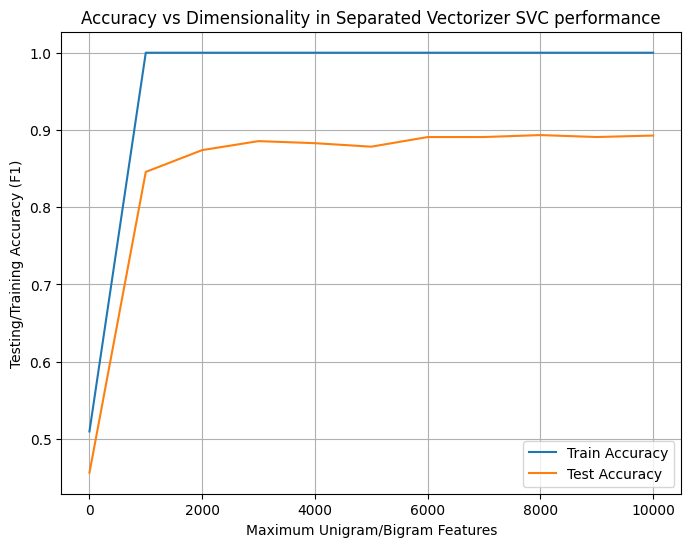

In [9]:
plt.figure(figsize=(8,6))
plt.plot(max_feats, trainaccs, label="Train Accuracy")
plt.plot(max_feats, testaccs, label="Test Accuracy")
plt.xlabel("Maximum Unigram/Bigram Features")
plt.ylabel("Testing/Training Accuracy (F1)")
plt.title("Accuracy vs Dimensionality in Separated Vectorizer SVC performance")
plt.legend()
plt.grid()
plt.show()

# Training (Combined Approach)

In [10]:
# Features and target
X = df_concat.drop('fraudulent', axis=1)
y = df_concat['fraudulent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (14304, 10)
Testing set: (3576, 10)


In [11]:
trainaccs2 = []
testaccs2 = []
max_feats = [5, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]

for item in max_feats:
    # TF-IDF for text
    text_transformer2 = TfidfVectorizer(max_features=item, ngram_range=(1,2), min_df=5, sublinear_tf=True)

    # Categorical features
    categorical_transformer2 = OneHotEncoder(handle_unknown='ignore')

    # Combine
    preprocessor2 = ColumnTransformer(
        transformers=[
            ('desc_tfidf', text_transformer2, 'text_features'),
            ('cat', categorical_transformer2, categorical_features),
            ('num', 'passthrough', ['telecommuting', 'has_company_logo', 'has_questions'])
        ],
        remainder='drop'
    )

    # Define SVM pipeline
    svm_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor2),
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False because of sparse TF-IDF
        ('classifier', SVC(kernel='linear', C=0.01, class_weight='balanced', probability=True, random_state=1))
    ])

    svm_pipeline.fit(X_train, y_train)

    y_prob1 = svm_pipeline.predict_proba(X_train)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob1)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]

    trainaccs2.append(best_f1)
    
    y_prob2 = svm_pipeline.predict_proba(X_test)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob2)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]

    testaccs2.append(best_f1)

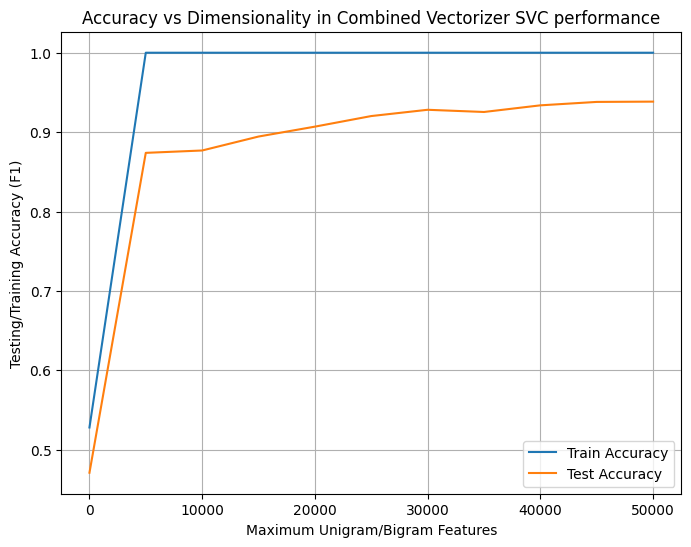

In [12]:
plt.figure(figsize=(8,6))
plt.plot(max_feats, trainaccs2, label="Train Accuracy")
plt.plot(max_feats, testaccs2, label="Test Accuracy")
plt.xlabel("Maximum Unigram/Bigram Features")
plt.ylabel("Testing/Training Accuracy (F1)")
plt.title("Accuracy vs Dimensionality in Combined Vectorizer SVC performance")
plt.legend()
plt.grid()
plt.show()

# WordCloud Generation

In [13]:
best_pipe = best_model_C

coefs = best_pipe.named_steps['classifier'].coef_

if hasattr(coefs, "toarray"):
    coefs = coefs.toarray()

coefs = coefs.flatten()

feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()

importances = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(coefs)
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print(importances.head(20))


NameError: name 'best_model_C' is not defined

In [ ]:
desc = {}

for i, row in importances.iterrows():
    if "desc_tfidf__" in row['feature']:
        desc[row['feature'].replace("desc_tfidf__", "")] = row['importance']
    else:
        pass

cloud = WordCloud(background_color="white",
    width=1000,
    height=1000,
    max_words=20,
    relative_scaling=1,
    normalize_plurals=False).generate_from_frequencies(desc)

plt.imshow(cloud)

In [ ]:
from MLstatkit.stats import Delong_test


y_test = df_sep['fraudulent']
y_probS = best_model_S.predict_proba(df_sep)[:, 1]
y_probC = best_model_C.predict_proba(df_concat)[:, 1]

In [ ]:
z_score, p_value = Delong_test(y_test, y_probC, y_probS)

print(f"z-score: {z_score}, P-Value: {p_value}")